In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np_force
import scipy as sc_force
import autograd.numpy as np
import autograd.scipy as sc
from autograd import grad, elementwise_grad, value_and_grad, grad_and_aux
from matplotlib import pyplot as plt
from skimage.transform import resize as imresize
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
from IPython import display
import scipy.ndimage as ndim
import scipy.misc as misc
from autograd.scipy import signal
from os import listdir
from os.path import isfile, join
import matplotlib.animation as animation
from os import listdir
from os.path import isfile, join
import autogradLenslets_utils as ag_utils
from autogradLenslets_utils import rgb2imshow
import copy

/Users/nick.antipa/anaconda/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


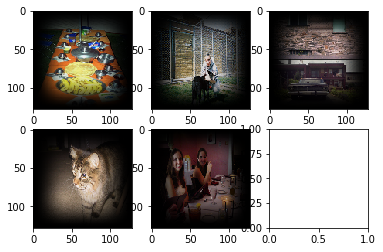

In [2]:

samples = (64,64)
Ntrain = 10
Nbatch = 6
Nval = 5
dataset_dir = '/Users/nick.antipa/Documents/TrainingData/NaturalImages512/'

train_list, val_list = ag_utils.load_training_ims(samples, dataset_dir, Ntrain, Nbatch, Nval)

# Display some of the training data
subrows = int(np.floor(np.sqrt(Nval)))
subcols = int(np.ceil(np.sqrt(Nval)))
fig, ax = plt.subplots(subrows, subcols)#, figsize=(20,20))
c = -1
for n in range(subrows):
    for m in range(subcols):
        c += 1
        if c < Nval:
            ax[n,m].imshow(np.moveaxis(val_list[c], 0, -1))

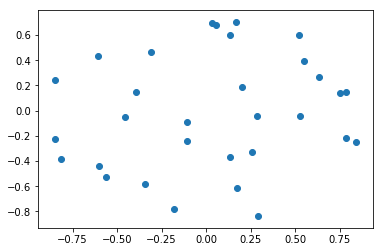

In [3]:
Nlenslets = 50

xrng = (-1,1)
yrng = (-1,1)
x1 = np.random.rand(Nlenslets)*2-1

y1 = np.random.rand(Nlenslets)*2-1
x1, y1 = ag_utils.project_to_aperture(x1, y1, .9, mode='delete')
R = np.random.rand(Nlenslets)*5+16

xg = np.linspace(xrng[0], xrng[1], samples[0])
yg = np.linspace(yrng[0], yrng[1], samples[1])
xg, yg = np_force.meshgrid(xg,yg)
ca = .9
aperR = np.sqrt(xg**2 + yg**2)<ca
plt.figure()
plt.scatter(x1,y1)

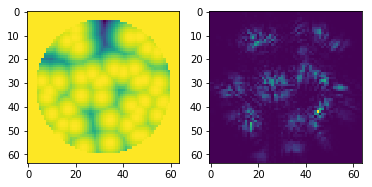

In [4]:
ps = (xrng[1] - xrng[0])/samples[0]
lens_rad = 12
lens_curv = 1/lens_rad
lens_f = 1/(.51/lens_rad)
x_list = np.random.rand(50)*1.8 - .9
y_list = np.random.rand(50)*1.8 - .9
#ltest = make_lens_surface_ag(lens_rad, xg, yg)
ltest = ag_utils.make_lenslet_surface_ag(x_list, y_list, lens_curv, xg, yg,mode='curvature')
fx = np.linspace(-1/2/ps,1/2/ps,ltest.shape[1])
fy = np.linspace(-1/2/ps,1/2/ps, ltest.shape[0])
Fx,Fy = np.meshgrid(fx,fy)

#ltest = make_lenslet_surface_ag(Xlist, Ylist, Rlist, xg, yg, offset):


fig = plt.figure(figsize=(20,10))




f,ax = plt.subplots(1,2)

ax[0].imshow(ltest*aperR)
defocus_list = np.linspace(lens_f-20,lens_f+20,10)
field_list = np.linspace(0,0,1)
for defocus in defocus_list:
    for field in field_list:
        fld = tuple([2*field,0])
        test = ag_utils.gen_psf_ag(ltest, 1.51, defocus, 'inf', 'angle',fld,.8,550e-6, xg, yg, Fx, Fy, 0, prop_pad = .5)

        ax[1].imshow(test)
        display.display(f)
        display.clear_output(wait=True)


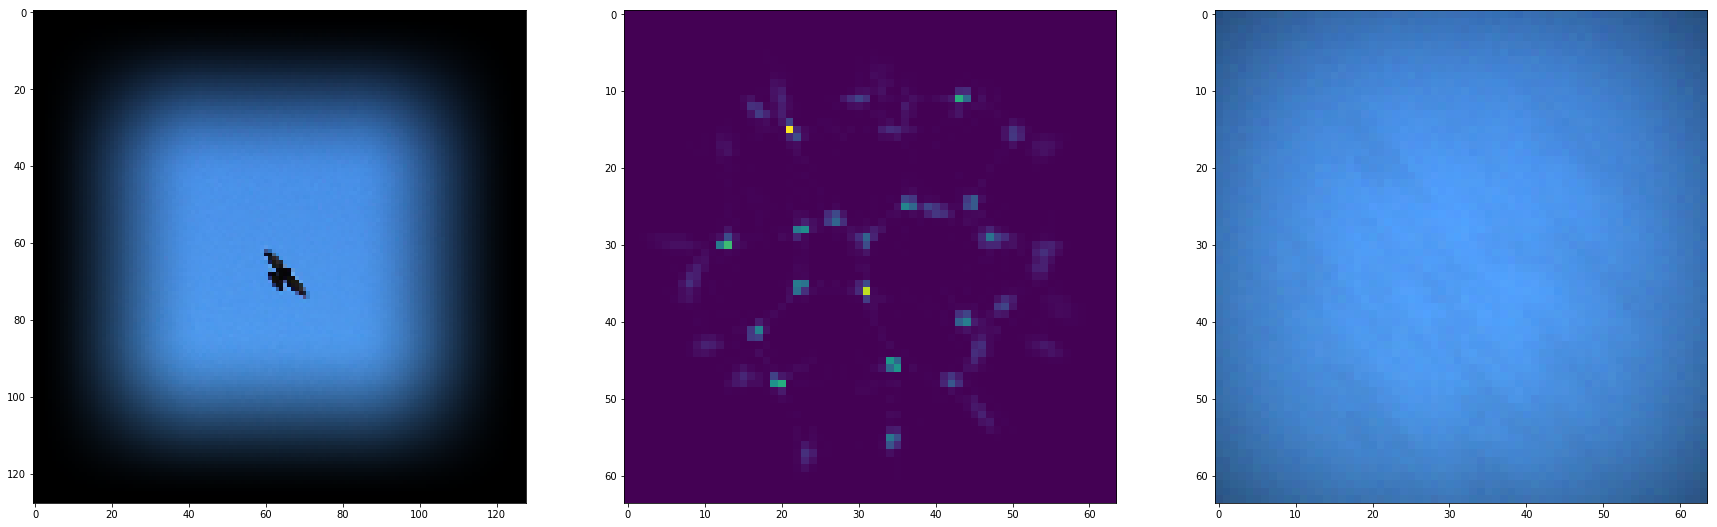

In [5]:
test_im = train_list[6]
psf = ag_utils.gen_psf_ag(ltest, 1.51, lens_f, 'inf', 'angle', fld, .8, 550e-6, xg, yg, Fx, Fy, 0, .2)
meas_test = ag_utils.forward_sim(psf,test_im)


plt.figure(figsize=(30,10))
plt.subplot(131)
plt.imshow(rgb2imshow(test_im))
plt.subplot(132)
plt.imshow(psf)
plt.subplot(133)
plt.imshow(rgb2imshow(meas_test))

l2 Error:
7.770010882464176


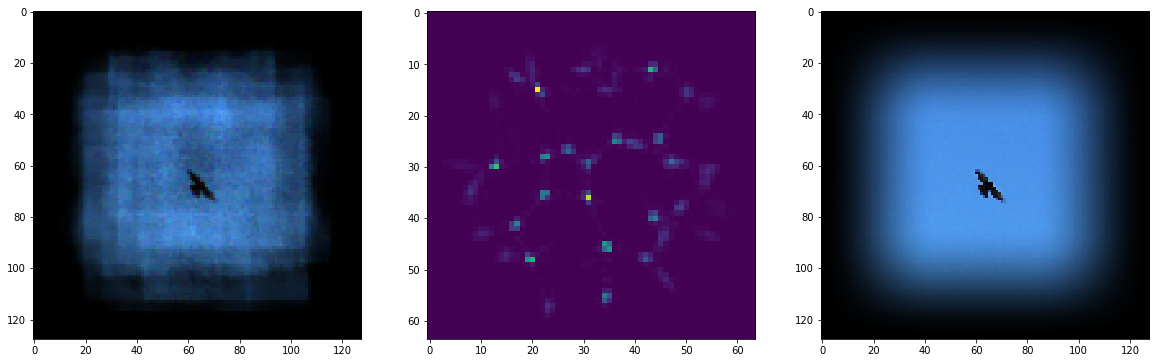

In [6]:
reconned = np.array([ag_utils.admm2d(np.squeeze(meas_test[n,:,:]), psf, 5e-5, 100, options = ag_utils.gen_options(mu1=.2, mu2 = .1, mu3 = .1)) for n in range(meas_test.ndim)])

fig, ax = plt.subplots(1,3,figsize=(20,10))
err_im = ag_utils.crop_func(reconned-test_im, (3,samples[0], samples[1]))
print("l2 Error:")
print(np.linalg.norm(err_im.ravel()))
ax[0].imshow(rgb2imshow(reconned))
ax[1].imshow(psf)
ax[2].imshow(rgb2imshow(test_im))


(3, 128, 128)
restarting
restarting


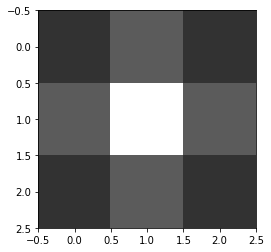

In [14]:
H = np.expand_dims(np.fft.fft2(np.fft.ifftshift(ag_utils.pad_func(psf, .5))), 0)
H_adj = np.conj(H)
stepsize_fista = 2.1

niter_fista = 200
tau = .005

db = 0
k1 = .1+np.repeat(np.expand_dims(np.array([[0, -1, 0],[-1, 4, -1],[0, -1, 0]]),0), 3, axis=0)
k2 = np.fft.fftshift(np.real(np.fft.ifft2(1/np.fft.fft2(np.fft.ifftshift(k1, axes=(1,2))))), axes=(1,2))
plt.figure()
plt.imshow(rgb2imshow(k2))

A = lambda x:ag_utils.crop_func(np.real(np.fft.ifft2(np.fft.fft2(x) * H)), (3,psf.shape[0],psf.shape[1]))
A_adj = lambda y:np.real(np.fft.ifft2(np.fft.fft2(ag_utils.pad_func(y,((0,0), (.5,.5), (.5,.5)))) * H_adj))
b = meas_test
#b = A(test_im) + .005*np.random.randn(3,np.shape(test_im)[-2]//2, np.shape(test_im)[-1]//2)
grad_func = lambda x:ag_utils.linear_gradient(x, A, A_adj, b)
prox_func = lambda x,n:ag_utils.soft_wavelets_skimage_cycle(x, tau, n, pos=True, ycbcr = True)
#prox_func = lambda x,n:np.maximum(x,0)
#prox_func = lambda x,n:ag_utils.prox4learningRGB(x, [k1,k2],[-db, -db])
#prox_func = lambda x,n:x
thresh = -.000005
#prox_func = lambda x,n:prox4learning_wavelet_RGB(x, [ah, av, ad, aa], [sh, sv, sd, sa], [thresh, thresh, thresh, thresh])
print(np.shape(prox_func(test_im,0)))
y_k, f = ag_utils.FISTA(grad_func, prox_func, np.zeros(np.shape(test_im)), stepsize_fista, niter_fista, do_restarting = True)
mse_FISTA = np.sum(np.abs(y_k - test_im))/len(y_k.ravel())

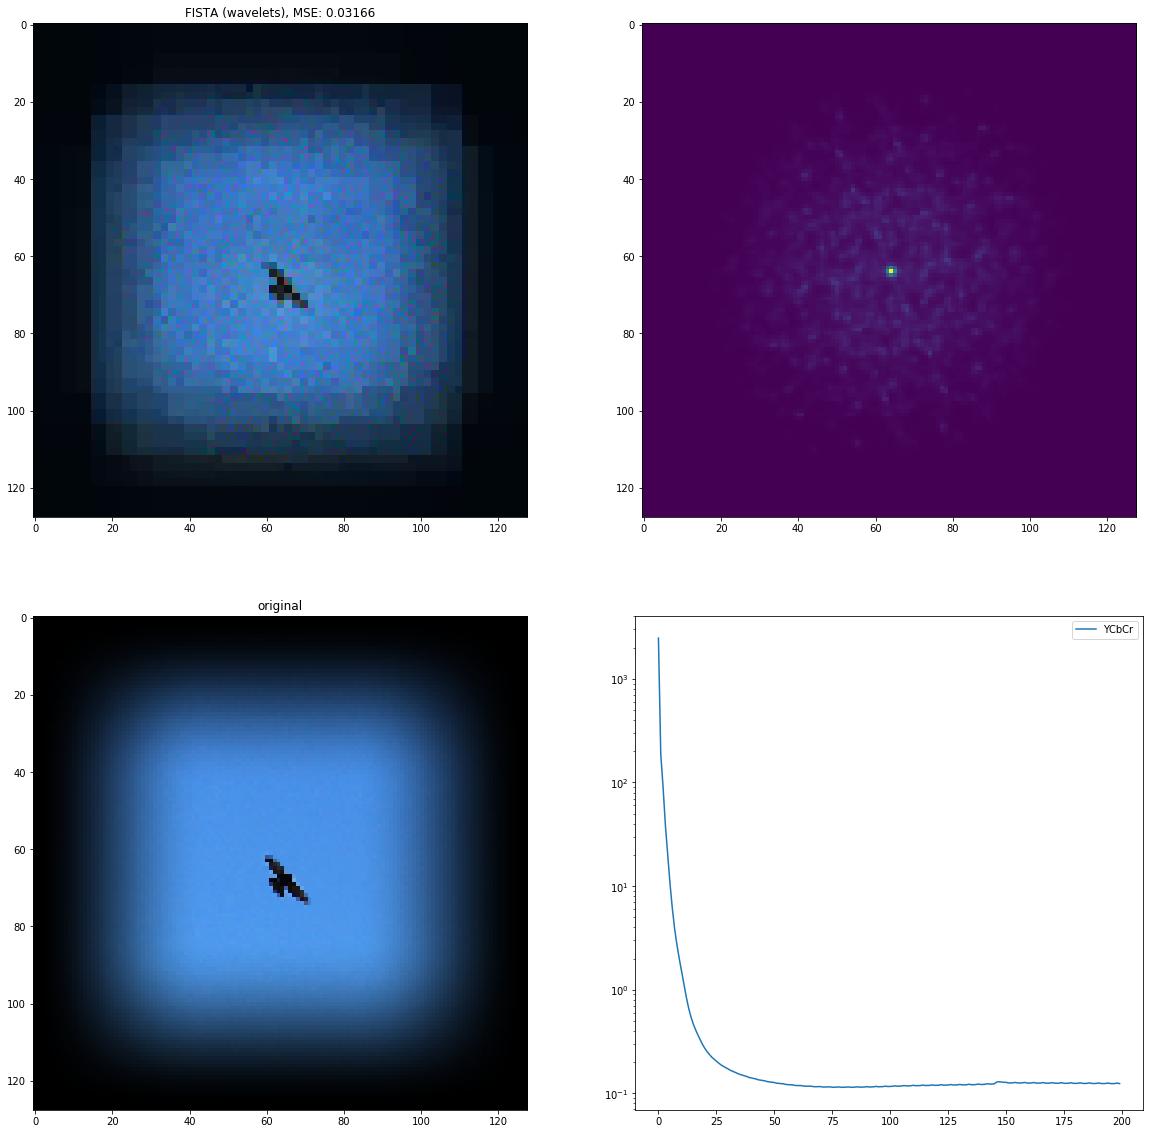

In [15]:
fig, ax = plt.subplots(2,2,figsize=(20,20))
ax[1,0].imshow(rgb2imshow(test_im))
ax[1,0].set_title('original')
ax[0,0].imshow(rgb2imshow(y_k))
ax[0,0].set_title('FISTA (wavelets), MSE: %.5f' %(mse_FISTA))
#ax[0,1].imshow(rgb2imshow(meas_test))
ax[0,1].imshow(np.squeeze(A_adj(np.expand_dims(psf,0))))
#ax[0,1].set_title('ADMM, MSE: %.5f' %(mse_rgb))
ax[1,1].semilogy(f, label='YCbCr')
#ax[1,1].semilogy(f2, label='ADMM')
ax[1,1].legend()

In [8]:
def resize(img, factor):
    num = int(-np.log2(factor))
    for i in range(num):
        img = 0.25*(img[::2,::2,...]+img[1::2,::2,...]+img[::2,1::2,...]+img[1::2,1::2,...])
    return img    


In [9]:
# # Testing FISTA
# psf = np.load('/Users/nick.antipa/Downloads/psf.npy')
# meas_test = np.load('/Users/nick.antipa/Downloads/data.npy')
# print(np.shape(meas_test))

# plt.figure()
# #H = np.expand_dims(np.fft.fft2(np.fft.ifftshift(ag_utils.pad_func(psf, .5))), 0)
# #H_adj = np.conj(H)
# H = np.expand_dims(np.load('/Users/nick.antipa/Downloads/h.npy'), 0)
# H_adj = np.expand_dims(np.load('/Users/nick.antipa/Downloads/hadj.npy'), 0)

# stepsize_fista = .8/np.max(np.abs(H*H_adj))
# A = lambda x:ag_utils.crop_func(np.real(np.fft.ifft2(np.fft.fft2(x, norm='ortho') * H, norm='ortho')), (3,psf.shape[0],psf.shape[1]))
# A_adj = lambda y:np.real(np.fft.ifft2(np.fft.fft2(ag_utils.pad_func(y,((0,0), (180.5/150,180.5/150), (156/200,156/200))), norm='ortho') * H_adj, norm='ortho'))
# b = meas_test
# grad_func = lambda x:ag_utils.linear_gradient(x, A, A_adj, b)
# prox_func = lambda x,n:x
# niter_fista = 300
# y_k, f = ag_utils.FISTA(grad_func, prox_func, np.zeros(np.shape(H)), stepsize_fista, niter_fista, do_restarting = False)

In [10]:
# plt.imshow(np.squeeze(y_k))
# plt.figure()
# plt.semilogy(f)

In [11]:
# from PIL import Image

# im_in = resize(sc_force.misc.imread("/Users/nick.antipa/Documents/Diffusers/Lensless/diffuser_flatcam/Baffle/baffle_hand.tif").astype('float32'), 1/8)
# psf_in = resize(sc_force.misc.imread("/Users/nick.antipa/Documents/Diffusers/Lensless/diffuser_flatcam/Box/psf_hdr/psf_box_exp8.tif").astype('float32'), 1/8)
# bg = np.mean(psf_in[0:15,0:15])
# psf_in -= bg
# psf_in = psf_in/np.sum(psf_in)
# im_in = im_in - bg
# H_in = np.expand_dims(np.fft.fft2(np.fft.ifftshift(ag_utils.pad_func(psf_in, .5))), 0)
# H_in_adj = np.conj(H_in)
# stepsize_fista = 2.1

# niter_fista = 200
# tau = .01


# A = lambda x:ag_utils.crop_func(np.real(np.fft.ifft2(np.fft.fft2(x) * H_in)), (3,psf_in.shape[0],psf_in.shape[1]))
# A_adj = lambda y:np.real(np.fft.ifft2(np.fft.fft2(ag_utils.pad_func(y,((0,0), (.5,.5), (.5,.5)))) * H_in_adj))
# b = im_in
# #b = A(test_im) + .005*np.random.randn(3,np.shape(test_im)[-2]//2, np.shape(test_im)[-1]//2)
# grad_func = lambda x:ag_utils.linear_gradient(x, A, A_adj, b)
# prox_func = lambda x,n:x

# y_k, f = ag_utils.FISTA(grad_func, prox_func, np.expand_dims(np.zeros((2*np.shape(im_in)[0], 2*np.shape(im_in)[1])),0), stepsize_fista, niter_fista, do_restarting = True)



In [12]:
# plt.figure(figsize=(20,20))
# plt.imshow(ag_utils.crop_func(np.squeeze(y_k), np.shape(psf_in)),cmap='gray')

In [13]:
def prox4learningRGB(x, kernel_list, bias_list):
    n_layers = np.shape(kernel_list)[0]

    size_in = np.shape(x)
    for n in range(n_layers):

        y = np.array([signal.convolve(x[m], kernel_list[n][m,:,:]) for m in range(3)])
        x = np.maximum(y + bias_list[n],0)
        #x = y
        
    return ag_utils.crop_func(x, size_in)

In [14]:
def prox4learningRGB_wavelet(x, analysis_list, synthesis_list, bias_list):
    n_layers = np.shape(analysis_list)[0]

    size_in = np.shape(x)
    z = np.zeros_like(x)
    for n in range(n_layers):
        y = np.maximum([signal.convolve(x[m], analysis_list[n][m,:,:]) for m in range(3)] + bias_list[n], 0)
        z += ag_utils.crop_func(np.array([signal.convolve(y[m], synthesis_list[n][m,:,:]) for m in range(3)]), size_in)
        
    
        
    return np.sum(z)

In [15]:
def prox4learning_wavelet(x, analysis_list, synthesis_list, bias_list):
    n_layers = np.shape(analysis_list)[0]

    size_in = np.shape(x)
    z = np.zeros_like(x)
    y_out = []
    zmask = np.zeros((np.shape(x)[0]+2, np.shape(x)[1]+2))
    zmask[::2, ::2] = 1
    zmask1 = np.ones_like(x)
    zmask1[::2, ::2] = 1
    

    for n in range(n_layers):
        s = signal.convolve(x, analysis_list[n])
        y = ag_utils.crop_func(np.maximum(np.abs(s) + bias_list[n], 0), size_in) * zmask1
        y = y * np.sign(ag_utils.crop_func(s, size_in))
        y_out.append(y)
        
        z += ag_utils.crop_func(signal.convolve(y, synthesis_list[n]), size_in)
        #z += signal.convolve(y, synthesis_list[n])
        
    
        
    return z, y_out

In [16]:
def prox4learning_wavelet_RGB(x, analysis_list, synthesis_list, bias_list):
    n_layers = np.shape(analysis_list)[0]
    
    size_in = np.shape(x)
    size_in_2d = (np.shape(x)[-2], np.shape(x)[-1])
    #z = np.zeros_like(x)
    #y_out = []
    z = []

    for n in range(n_layers):
        s = [ag_utils.crop_func(signal.convolve(x[m], analysis_list[n][m,:,:]), size_in_2d) for m in range(3)]
        y = [np.maximum(ag_utils.crop_func(np.abs(s[m]), size_in_2d) + bias_list[n], 0) for m in range(3)] 
        y = [y[m] * np.sign(s[m]) for m in range(3)]
        #y_out.append(y)
        
        z.append([ag_utils.crop_func(signal.convolve(y[m], synthesis_list[n][m,:,:]), size_in_2d) for m in range(3)])
        #z += signal.convolve(y, synthesis_list[n])
        
    
        
    return np.sum(np.array(z), axis=0)

In [17]:
a = [[1,2], [3,4]]

print(np.sum(np.array(a), axis=0))


[4 6]


(3, 128, 128)


NameError: name 'y_out' is not defined

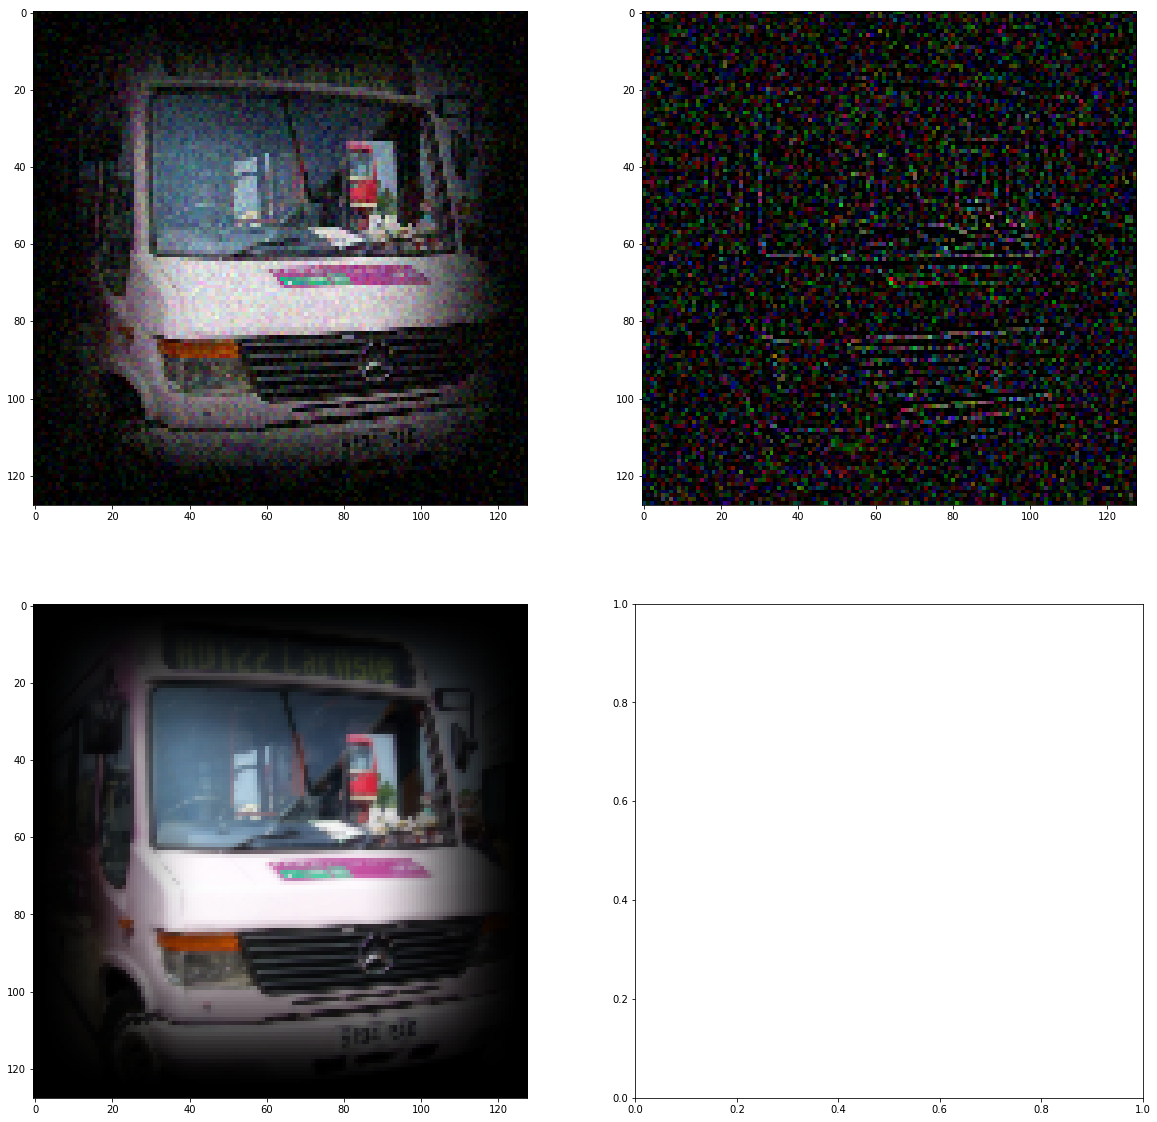

In [33]:
sc = 4

twod2threed = lambda x:np.repeat(np.expand_dims(x,0), 3, axis=0)
ah = twod2threed(np.array([[0, 0, 0],[0, 1, -1],[0, 0, 0]])/sc)
av = twod2threed(np.array([[0, 0, 0],[0, 1, 0],[0, -1, 0]])/sc)
ad = twod2threed(np.array([[0, 0, 0],[0, 1, 0],[0, 0, -1]])/sc)
aa = twod2threed(np.array([[0, 0, 0],[0, 1, 1],[0, 1, 1]])/sc)

sh = twod2threed(np.array([[0, 0, 0],[-1, 1, 0],[0, 0, 0]])/sc)
sv = twod2threed(np.array([[0, -1, 0],[0, 1, 0],[0, 0, 0]])/sc)
sd = twod2threed(np.array([[-1, 0, 0],[0, 1, 0],[0, 0, 0]])/sc)
sa = twod2threed(np.array([[1, 1, 0],[1, 1, 0],[0, 0, 0]])/sc)
asdf = copy.deepcopy(np.squeeze(test_im))
asdf = [asdf[m] + np.random.randn(np.shape(asdf)[-2], np.shape(asdf)[-1])*.05 for m in range(3)]
print(np.shape(asdf))
thresh = -0.00003
test = prox4learning_wavelet_RGB(test_im, [ah, av, ad, aa], [sh, sv, sd, sa], [thresh, thresh, thresh, thresh])

fig, ax = plt.subplots(2,2,figsize=(20,20))
ax[0,0].imshow(rgb2imshow(asdf))
ax[0,1].imshow(rgb2imshow(test-asdf))
ax[1,0].imshow(rgb2imshow(test))
ax[1,1].imshow(rgb2imshow(y_out[2]))


In [19]:
def prox4learning(x, kernel_list, bias_list):
    n_layers = np.shape(kernel_list)[0]

    for n in range(n_layers):
        y = signal.convolve2d(x, kernel_list[n])
        x = np.maximum(y - bias_list[n],0)
        #x = y
        
    return x

(3, 3)
(3, 128, 128)


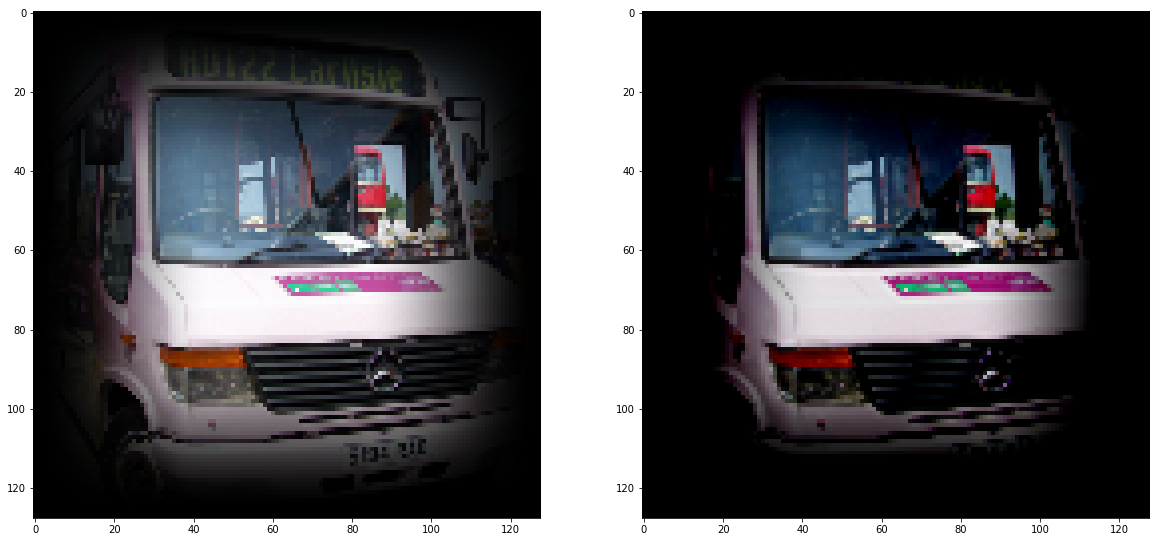

In [20]:

db = .03
kernel = np.array([[0, -1., 0],[-1., 15., -1.],[0, -1., 0]])

kernel = kernel/np.sum(kernel)
kinv = np.real(np.fft.fftshift(np.fft.ifft2(1/np.fft.fft2(np.fft.ifftshift(kernel)))))
k1 = np.repeat(np.expand_dims(kernel,0), 3, axis=0)
k2 = np.real(np.repeat(np.expand_dims(kinv,0), 3, axis=0))
k3 = k1
#print(np.shape(k1))
#k2 = np.fft.fftshift(np.real(np.fft.ifft2(1/np.fft.fft2(np.fft.ifftshift(k1, axes=(1,2))))), axes=(1,2))
#k2 = np.real(np.fft.ifft2(1/np.fft.fft2(k1)))
#test_mono = np.squeeze(test_im[2,:,:])
denoised = test_im
#kernels = [kr, krn, kr, krn, kr, krn]#, k2, k1, k2, k1, k2]
kernels = [k1, k2]
biases = [-.01, -.01]
print(np.shape(kernels[0][0,:,:]))

for n in range(10):
    denoised= prox4learningRGB(denoised, kernels,biases)

fig, ax = plt.subplots(1,2,figsize=(20,10))

ax[0].imshow(rgb2imshow(test_im))
#ax[1].imshow(k2[2,:,:])

ac = signal.convolve(kernel, kinv, mode='valid')
print(np.shape(denoised))
ax[1].imshow(rgb2imshow(denoised))


In [21]:
def loss_learn_prox_FISTA(kernels1, kernels2, biases, R_lenslet_learning, x_list_learning, y_list_learning, prop_distance, lens_ior, iters, im_list, Nims=-1, lens_mode = 'radius', ilist = -1):

   
    if Nims == -1:
        Nims = len(im_list)
    
    if ilist == -1:
        im_subs = np.random.choice(len(im_list), Nims, replace=False)
    else:
        im_subs = ilist
    im_list = [im_list[im_subs[n]] for n in range(Nims)]
    
    surface_lenslets = ag_utils.make_lenslet_surface_ag(x_list_learning, y_list_learning, R_lenslet_learning, xg, yg, mode=lens_mode)
    psf = ag_utils.gen_psf_ag(surface_lenslets, lens_ior, prop_distance, 'inf', 'angle', (0,0), .9, 550e-6, xg, yg, Fx, Fy, 0, .2)

    if im_list[0].ndim == 3:
        meas_lenslets = [ag_utils.forward_sim(psf, im_list[n]) for n in range(len(im_list))]
        crop_tuple = (3, int(im_list[0].shape[-2]//2), int(im_list[0].shape[-1]//2))
    else:
        meas_lenslets = [np.expand_dims(ag_utils.forward_sim(psf, im_list[n]),0) for n in range(len(im_list))]
        crop_tuple = (int(np.shape(im_list[0])[-2]//2), int(np.shape(im_list[0])[-1]//2))

    # 
    # Recon
    
    H = np.expand_dims(np.fft.fft2(np.fft.ifftshift(ag_utils.pad_func(psf/np.sum(psf), .5))), 0)
    H_adj = np.conj(H)

    A = lambda x:ag_utils.crop_func(np.real(np.fft.ifft2(np.fft.fft2(x) * H)), (3,psf.shape[0],psf.shape[1]))
    A_adj = lambda y:np.real(np.fft.ifft2(np.fft.fft2(ag_utils.pad_func(y,((0,0), (.5,.5), (.5,.5)))) * H_adj))
    
    recon_lenslets=[]
    for m in range(len(im_list)):
        grad_func = lambda x:ag_utils.linear_gradient(x, A, A_adj, meas_lenslets[m])
        g, f = grad_func(np.expand_dims(ag_utils.pad_func(psf,((.5,.5),(.5,.5))),0))

        #prox_func = lambda x,n:prox4learningRGB(x, kernels, biases)
        prox_func = lambda x,n:prox4learning_wavelet_RGB(x, kernels1, kernels2, biases)
        #prox_func = lambda x,n:x

        stepsize_fista = 1.8

        recon, f = ag_utils.FISTA(grad_func, prox_func, np.zeros(np.shape(im_list[m])), stepsize_fista, iters, do_restarting = False)
        recon_lenslets.append(recon)
        
    
    resid_im_lenslets = [ag_utils.crop_func(recon_lenslets[m] - im_list[m], crop_tuple) for m in range(len(im_list))]

    loss_lenslets = np.sum([np.linalg.norm(resid_im_lenslets[n].ravel()) for n in range(len(im_list))])/len(im_list) + 3*np.linalg.norm(np.array(kernels))
    
    out_dict = {
        "resid_im" : resid_im_lenslets,
        "recon" : recon_lenslets,
        "loss" : loss_lenslets,
        "psf" : psf,
        "meas" : meas_lenslets,
        "kernels" : kernels,
        "biases" : biases
    } 
    
    
    return loss_lenslets, out_dict

23
0.3792087076863981


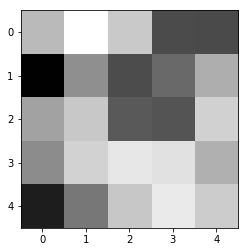

In [44]:

ior_lenslets = 1.51
target_rad_lenslets = lens_rad
target_curv_lenslets = 1/target_rad_lenslets
f_lenslets = target_rad_lenslets/(ior_lenslets-1)


R_list = target_curv_lenslets
learning_grad = grad_and_aux(loss_learn_prox_FISTA, argnum=(0,1,2))
kseed = np.random.rand(5,5)
kseed = kseed/np.sum(kseed.ravel())
kr = [copy.deepcopy(kseed) for n in range(3)]
kr = kr/np.sum(kr)*3
knseed = np.random.randn(5,5)

knseed = knseed/np.sum(knseed.ravel())
krn = [copy.deepcopy(knseed) for n in range(3)]
krn = krn/np.sum(krn)*3
kernels = [kr, krn, kr, krn, kr, krn]#, k2, k1, k2, k1, k2]
#kernels = [k1, k2, k1, k2, k1, k2]
kernels_kp = kernels
biases = [-.000003 for n in range(len(kernels))]

td = [[0,2,3],[5,6,7]]
print(np.sum(td))
print(np.linalg.norm(kernels[0].ravel()))
plt.figure()
plt.imshow(rgb2imshow(kernels[0]))


kernels1 = [ah, av, ad, aa]
kernels2 = [sh, sv, sd, sa]
kernels1_kp = kernels1
kernels2_kp = kernels2

41


KeyboardInterrupt: 

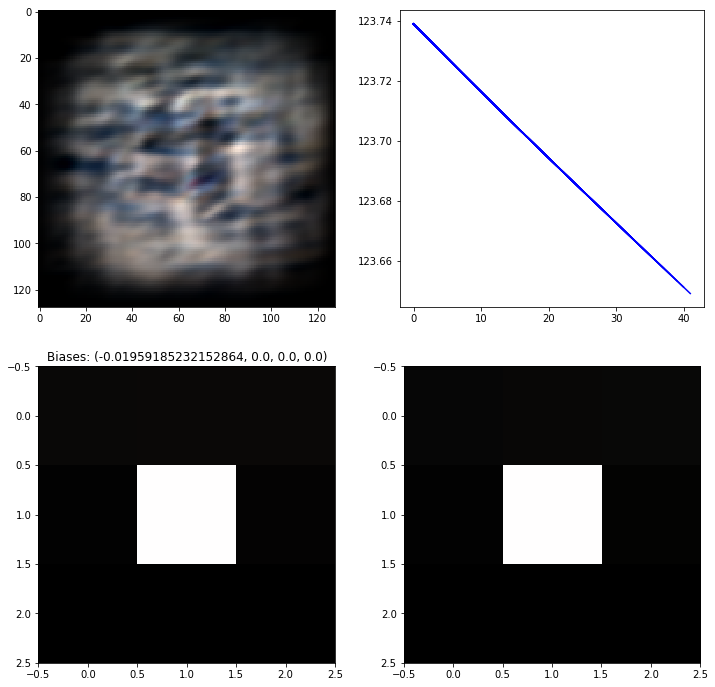

In [50]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
vals = []
mu1 = .00002
mu2 = .00002
t_k = 0
training_iters = 2000
ims = []
for n in range(training_iters):
    g, a = learning_grad(kernels1, kernels2, biases, R_list, x_list, y_list, f_lenslets, ior_lenslets, 20, train_list[:1],lens_mode='curvature')
    #print(type(g[0]))
    #print(np.shape(kernels))
    kernels1_kp = [kernels1[m] - mu1 * g[0][m] for m in range(len(kernels1))]
    kernels2_kp = [kernels2[m] - mu1 * g[1][m] for m in range(len(kernels2))]
    biases = [biases[m] - mu2 * g[2][m] for m in range(len(kernels1))]

    t_kp = (1 + np.sqrt(1+4*t_k**2)) / 2
    beta_kp = (t_k - 1)/t_kp
    beta_kp = 0
    dx1 = [kernels1_kp[m] - kernels1[m] for m in range(len(kernels1))]
    dx2 = [kernels2_kp[m] - kernels2[m] for m in range(len(kernels2))]
    kernels1 = [kernels1_kp[m] + beta_kp*dx1[m] for m in range(len(kernels1))]
    kernels2 = [kernels2_kp[m] + beta_kp*dx2[m] for m in range(len(kernels2))]
    t_k = t_kp
    vals.append(a['loss']._value)
    implot1 = ax[0,0].imshow(rgb2imshow(a['recon'][0]._value), animated=True)
    plot1, = ax[0,1].plot(vals, 'b',label='train')
    implot2 = ax[1,0].imshow(rgb2imshow(kernels1[1]), animated=True)
    
    biases = [np.minimum(biases[m],0) for m in range(len(kernels1))]
    biases = [np.maximum(biases[m],-1) for m in range(len(kernels1))]
    ax[1,0].set_title('Biases: %s' %(tuple([biases[m] for m in range(len(kernels1))]),))
    implot3 = ax[1,1].imshow(rgb2imshow(kernels1[-2]), animated=True)
    
    ims.append([plot1, implot1, implot2, implot3])
    print(n)
    if n % 10 == 0:
        display.display(fig)
        display.clear_output(wait=True)

In [ ]:
ani = animation.ArtistAnimation(fig, ims, interval=100, blit = True, repeat_delay=10)
HTML(ani.to_html5_video())

#ax[0,0].imshow(rgb2imshow(a['recon'][0]._value))